In [1]:
import warnings

import torch
import matplotlib.pyplot as plt
import numpy as np
from torch.distributions.transforms import PositiveDefiniteTransform

import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist
from pyro.contrib.gp.models import GPModel
from pyro.infer import MCMC, HMC, NUTS, Predictive

import arviz as az

In [2]:
pyro.set_rng_seed(545711891)
torch.set_default_dtype(torch.float64)

testing = False # TODO: set to False

In [3]:
# Constants
n_train = 20
n_test = 10
N = n_train + n_test
beta = 100
X = torch.linspace(0.0, 1.0, N) # grid of observations
x_axis = torch.linspace(0.0, 1.0, 100) # used for graphing

# We optimize the following parameters:
# variance, lengthscale, period, noise
params = ("kernel_var", "kernel_length", "kernel_period", "noise")

In [4]:
dist.LogNormal(-5.0, 1.0).sample()

tensor(0.0106)

In [5]:
# We choose a periodic kernel,
# as the function we are fitting has periodic tendencies.
def kernel(X, Z, var, length, period):
    d = X.unsqueeze(1).unsqueeze(1) - Z.unsqueeze(1).unsqueeze(0)
    scaled_sin = torch.sin(torch.pi * d / period) / length
    return var * torch.exp(-2 * (scaled_sin**2).sum(-1))

In [6]:
# For the model, we keep the noise a fixed parameter,
# and make all of the other parameters (variance, lengthscale, period) variable.
class Model():
    def __init__(self):
        pass

    def __call__(self, X, y=None):
        # As we don't want any of the kernel parameters to be negative,
        # we use lognormal priors.
        var    = pyro.sample("kernel_var",    dist.LogNormal(0.0, 1.0))
        length = pyro.sample("kernel_length", dist.LogNormal(0.0, 1.0))
        period = pyro.sample("kernel_period", dist.LogNormal(0.0, 1.0))
        noise  = pyro.sample("noise",         dist.LogNormal(-5.0, 0.5))

        # Compute the covariance with the chosen kernel
        cov = kernel(
            X, X,
            var=var, length=length, period=period
        )
        cov += noise * torch.eye(X.shape[0])

        # Sample predictive values as a gaussian.
        return pyro.sample(
            "y",
            dist.MultivariateNormal(loc=torch.zeros(X.shape[0]), covariance_matrix=cov),
            obs=y,
        )

In [7]:
# Function to learn
def g(x):
    return -(torch.sin(6*torch.pi*x))**2 + 6*x**2 - 5*x**4 + 3.0/2.0 

In [8]:
def sample_data(X, n_train, n_test):
    N = n_train + n_test
    # Partition sample points
    idx = np.random.permutation(N)
    X = X[idx]
    # Sample y_i = g(x_i) + ϵ
    noise = dist.Normal(0.0, beta**-1).sample(sample_shape=(N,))
    y = g(X) + noise
    return X[:n_train], y[:n_train], X[n_train:], y[n_train:]

In [9]:
def predict(X, y, X_pred, var, length, period, noise):
    N = X.shape[0]
    eta = (var, length, period)
    # Follow simple GP algorithm from p. 40
    # of Oswin's notes.
    K_S =  kernel(X, X, *eta)
    K_Sx = kernel(X, X_pred, *eta)
    K_xx = kernel(X_pred, X_pred, *eta)
    G = torch.linalg.inv(noise * torch.eye(N) + K_S)
    a = torch.matmul(G, y)
    mustar = torch.matmul(K_Sx.T, a)
    Sigmastar = K_xx - torch.matmul(torch.matmul(K_Sx.T, G), K_Sx)
    return mustar, Sigmastar # return mean and covariance matrix

In [10]:
def plot_data(ax, X_train, y_train, X_test, y_test, plot_g=True):
    ax.plot(X_train, y_train, 'kx', label='train')
    ax.plot(X_test, y_test, 'k.', label='test')
    if plot_g:
        ax.plot(x_axis, g(x_axis), 'r-', label='g(x)')
    ax.legend()

In [11]:
def plot_prior_samples(ax, model, n_samples=1):
    N = len(x_axis)
    samples = np.array(
        [model(x_axis).detach().numpy() for _ in range(n_samples)]
    )
    ax.plot(x_axis, samples.T, lw=2)

In [12]:
def plot_predictions(ax, X, mean, cov):
    mean = mean.detach().numpy()
    sd = cov.diag().sqrt().detach().numpy()
    ax.plot(X, mean, "g", lw=2, label="GP prediction")  # plot the mean
    ax.fill_between(
        X,  # plot the two-sigma uncertainty about the mean
        (mean - 2.0 * sd),
        (mean + 2.0 * sd),
        color="C0",
        alpha=0.3,
        label="GP uncertainty"
    )
    ax.legend()

In [13]:
def plot_loss(ax, loss):
    ax.plot(loss)
    ax.set_xlabel("Iterations")
    ax.set_ylabel("Loss")

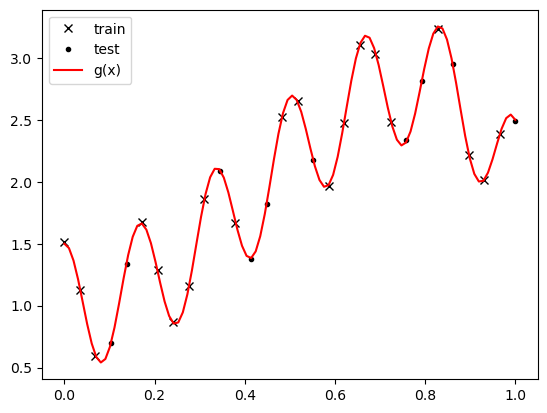

In [14]:
# Sample and plot the data
X_train, y_train, X_test, y_test = sample_data(X, n_train, n_test)
fig, ax = plt.subplots()
plot_data(ax, X_train, y_train, X_test, y_test)

# Training via variational inference

In [15]:
model = Model()

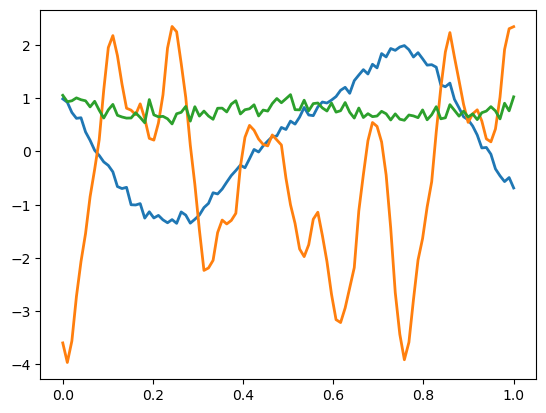

In [16]:
# Samples of unlearned GP
fig, ax = plt.subplots()
plot_prior_samples(ax, model, n_samples=3)

In [17]:
# Compute MAP estimate via gradient descent.
pyro.clear_param_store()

guide=pyro.infer.autoguide.AutoDelta(model)
optim=pyro.optim.Adam({"lr": 0.01})
svi=pyro.infer.SVI(model, guide, optim, loss=pyro.infer.Trace_ELBO())

num_steps = 2000 if not testing else 100
losses = []
for i in range(num_steps):
    print(f"Training step {i+1}/{num_steps}", end="")
    loss = svi.step(X_train, y_train)
    losses.append(loss)
print()

# Extract learned parameters
var, length, period, noise = [pyro.get_param_store()["AutoDelta." + param] for param in params]

Training step 2000/2000


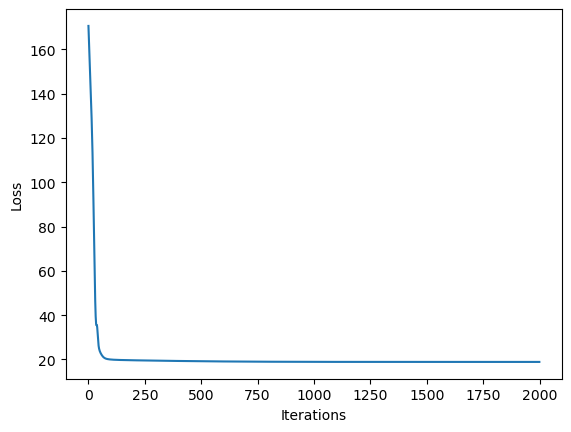

In [18]:
# Plot losses
fig, ax = plt.subplots()
plot_loss(ax, losses)

True


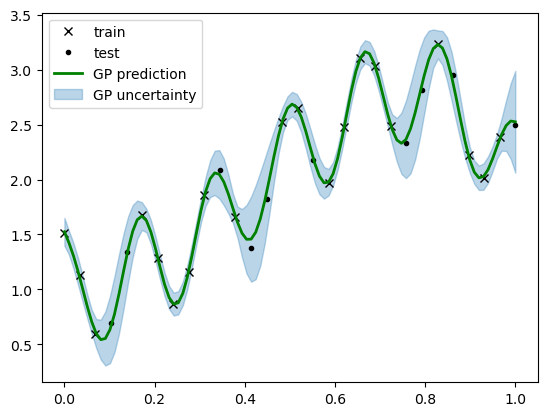

In [19]:
mean_pred, cov_pred = predict(X_train, y_train, x_axis, var, length, period, noise)
print(torch.allclose(cov_pred, cov_pred.T))

fig, ax = plt.subplots()
plot_data(
    ax=ax,
    X_train=X_train, y_train=y_train,
    X_test=X_test, y_test=y_test,
    plot_g=False,
)
plot_predictions(ax=ax, X=x_axis, mean=mean_pred, cov=cov_pred)

In [20]:
# Calculate the log-likelihood of the predictions on the test data
mean_pred, cov_pred = predict(X_train, y_train, X_test, var, length, period, noise)
log_likelihood = dist.MultivariateNormal(
    mean_pred,
    cov_pred
).log_prob(y_test)
print(f"Log-likelihood of test samples: {log_likelihood}")

Log-likelihood of test samples: 12.600064368768647


# Training via MCMC with NUTS

In [21]:
model = Model()

In [22]:
pyro.clear_param_store()

# Hyper-parameters for learning
warmup_steps = 1000 if not testing else 10
num_samples = 1000 if not testing else 10
num_chains = 5

nuts_kernel = NUTS(
    model=model,
    jit_compile=True,
)
mcmc = MCMC(
    nuts_kernel,
    num_samples=warmup_steps,
    warmup_steps=num_samples,
    num_chains=num_chains,
)
mcmc.run(X_train, y_train)

/usr/lib/python3.12/site-packages/pyro/infer/mcmc/api.py:499: UserWarning: num_chains=5 is more than available_cpu=3. Chains will be drawn sequentially.
  warnings.warn(





ample [4]: 100%|████████████████████████████████████| 2000/2000 [00:52, 38.39it/s, step size=1.68e-01, acc. prob=0.318]                                                      

In [23]:
samples = mcmc.get_samples()
posterior_params = [samples[param] for param in params]

                mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
kernel_length  0.685  0.884   0.072    2.521      0.297    0.217      11.0   
kernel_period  1.793  0.918   1.015    3.329      0.037    0.026     612.0   
kernel_var     3.183  1.479   0.890    5.717      0.091    0.064      59.0   
noise          0.021  0.030   0.001    0.083      0.012    0.009       9.0   

               ess_tail  r_hat  
kernel_length      37.0   1.39  
kernel_period    1022.0   1.01  
kernel_var         43.0   1.06  
noise              35.0   1.49  


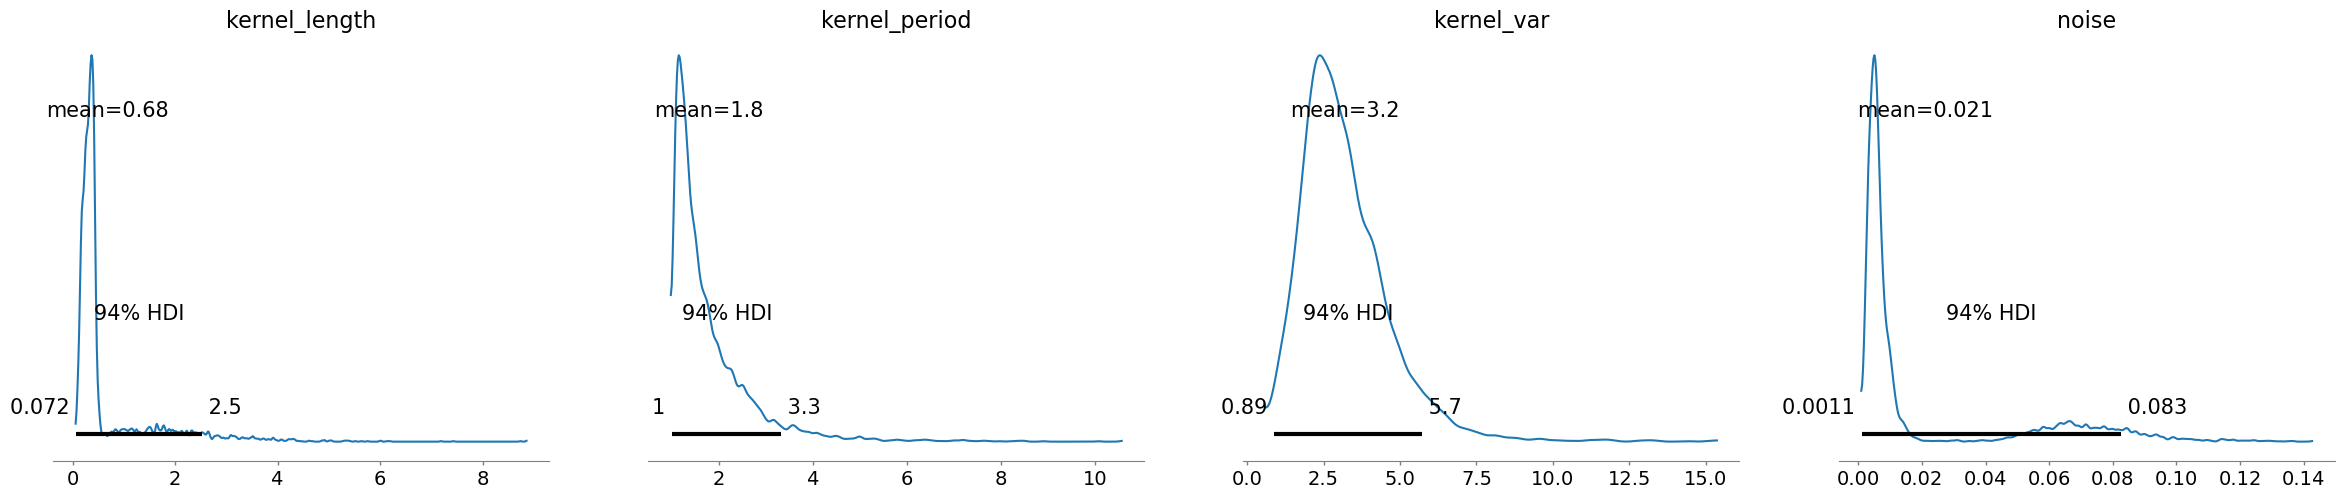

In [28]:
sample_data = az.from_pyro(mcmc, log_likelihood=False)
sample_summary = az.summary(sample_data)

print(sample_summary)
az.plot_posterior(sample_data)
plt.show()

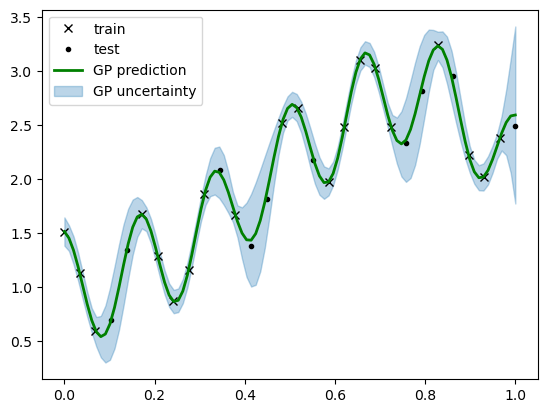

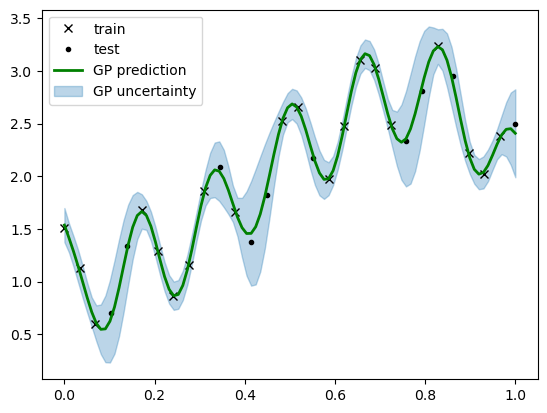

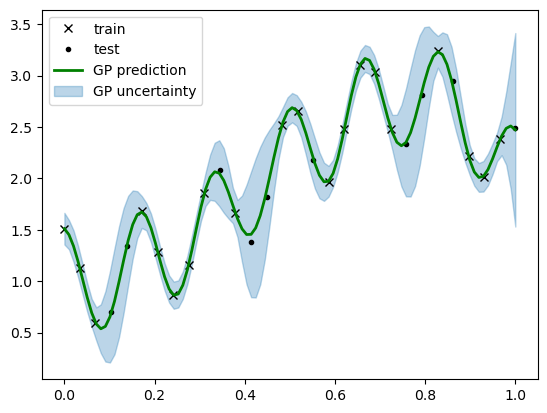

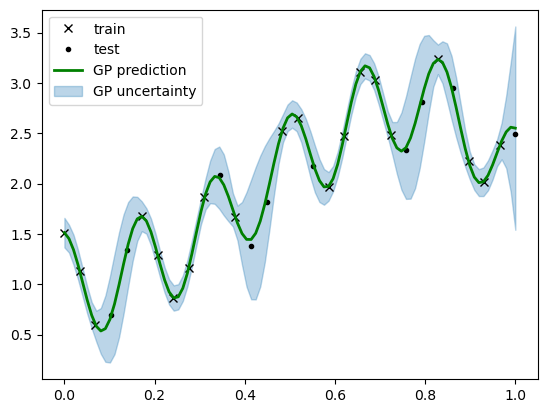

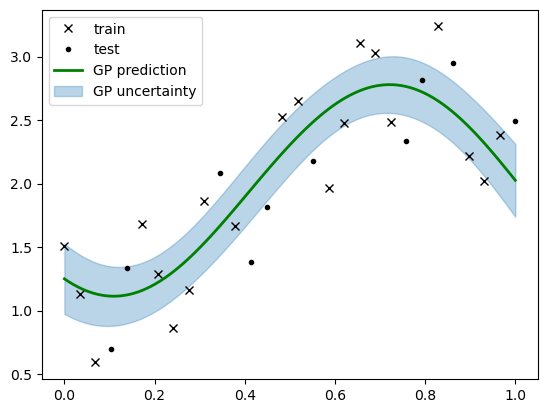

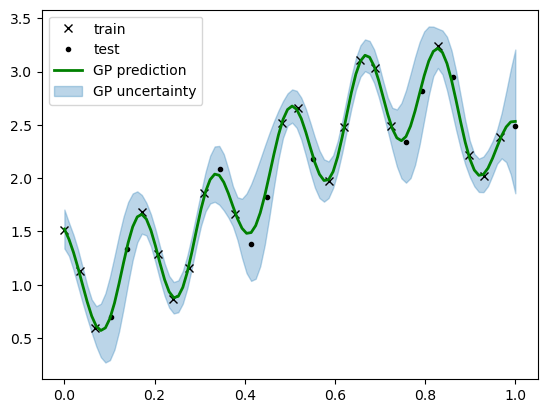

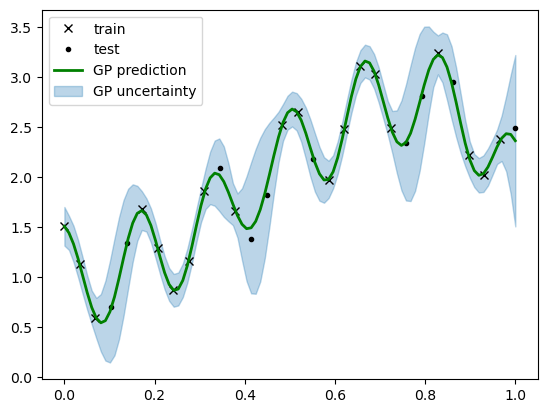

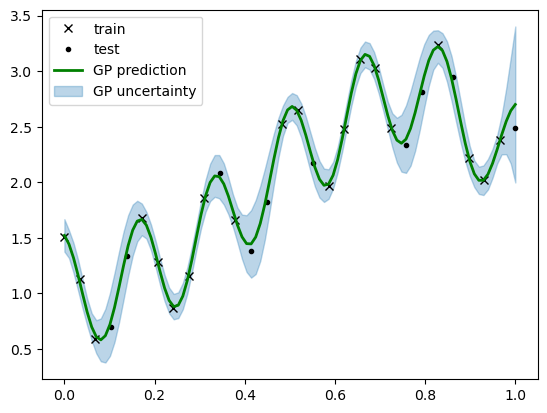

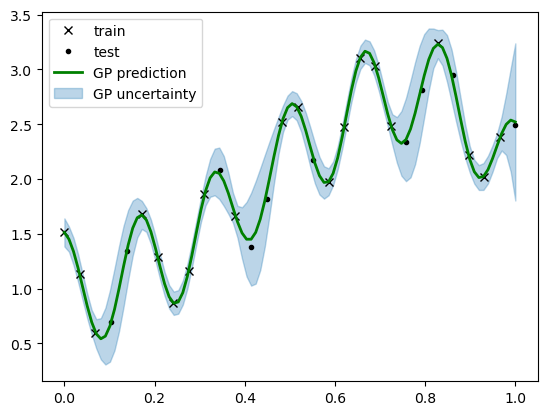

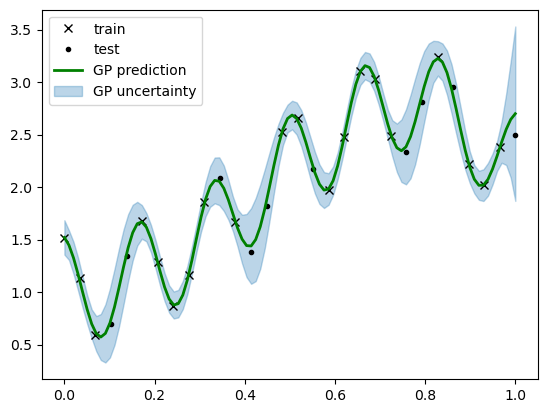

In [25]:
# plot 10 predictions over the x axis
mean_preds, cov_preds = torch.vmap(
    lambda var, length, period, noise: predict(
        X_train, y_train, x_axis, var, length, period, noise
    )
)(*posterior_params)

idx = np.random.randint(0, num_samples*num_chains, 10)
for i in range(10):
    j = idx[i]
    fig, ax = plt.subplots()
    plot_data(
        ax=ax,
        X_train=X_train, y_train=y_train,
        X_test=X_test, y_test=y_test,
        plot_g=False,
    )
    plot_predictions(ax=ax, X=x_axis, mean=mean_preds[j], cov=cov_preds[j])

In [26]:
# Calculate the log-likelihood of the average
# of the sampled predictions on the test data
mean_preds, cov_preds = torch.vmap(
    lambda var, length, period, noise: predict(
        X_train, y_train, X_test, var, length, period, noise
    )
)(*posterior_params)

mean_pred = torch.mean(mean_preds, axis=0)
cov_pred = torch.mean(cov_preds, axis=0)

log_likelihood = dist.MultivariateNormal(
    mean_pred,
    cov_pred
).log_prob(y_test)
print(f"Log-likelihood of test samples: {log_likelihood}")

Log-likelihood of test samples: 6.217640690291564
